In [1]:
%matplotlib inline
import numpy as np
from copy import copy
import math, random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import itertools

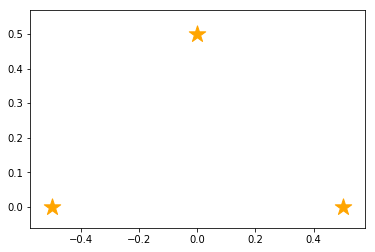

In [2]:
class Landmarks:
    def __init__(self, array):
        self.positions = array
        
    def draw(self):
        xs = [ e[0] for e in self.positions]
        ys = [ e[1] for e in self.positions]
        plt.scatter(xs, ys, s = 300, marker = "*", label = "landmarks", color = "orange")
        
actual_landmarks = Landmarks(np.array([[-0.5,0.0],[0.5,0.0],[0.0,0.5]]))

actual_landmarks.draw()

In [3]:
class Observation:
    def __init__(self,robot_pos, landmark,lid): 
        self.sensor_max_range = 1.0
        self.sensor_min_range = 0.1
        self.sensor_max_angle = math.pi / 2
        self.sensor_min_angle = - math.pi /2 
        
        self.lid = None
        
        rx, ry, rt = robot_pos[0], robot_pos[1], robot_pos[2]
        lx, ly = landmark[0], landmark[1]
        
        distance = math.sqrt((rx - lx)**2 + (ry - ly)**2)
        if distance > self.sensor_max_range or distance < self.sensor_min_range:
            return
        
        direction = math.atan2(ly - ry, lx - rx) - rt
        if direction > math.pi:    direction -= 2 * math.pi
        if direction < -math.pi:   direction += 2 * math.pi     
        if direction > self.sensor_max_angle or direction < self.sensor_min_angle:
            return
        
        orientation = direction + rt 
        if orientation > math.pi:     orientation -= 2*math.pi
        if orientation < -math.pi:   orientation += 2*math.pi   
        
        sigma_distance = distance * 0.03
        sigma_direction = math.pi * 3 / 180
        sigma_orientation = math.pi * 3 / 180
        
        self.distance = random.gauss(distance, sigma_distance)   
        self.direction = random.gauss(direction, sigma_direction)
        self.orientation = random.gauss(orientation, sigma_orientation)
        
        self.lid = lid
        
    def ellipse(self, robot_pos):
        rx, ry, rt = robot_pos[0], robot_pos[1], robot_pos[2]
        proposed_lx = rx + self.distance * math.cos(rt + self.direction)
        proposed_ly = ry + self.distance * math.sin(rt + self.direction)
        
        e = copy(self.error_ellipse)
        e.shift(np.array([proposed_lx, proposed_ly]).T, rt + self.direction)
        
        eig_vals, eig_vec = np.linalg.eig(e.cov)

        v1 = eig_vals[0] * eig_vec[:,0]
        v2 = eig_vals[1] * eig_vec[:,1]
        v1_direction = math.atan2(v1[1], v1[0])
        
        elli = Ellipse([proposed_lx, proposed_ly], width=np.linalg.norm(v1), height=np.linalg.norm(v2), angle=v1_direction / 3.14 * 180)
        elli.set_alpha(0.2)
        
        return elli
    
    def draw(self,sp, robot_pos):
        sp.add_artist(self.ellipse(robot_pos))

In [4]:
class Robot:
    def __init__(self, x, y, rad):
        random.seed()
        
        self.actual_poses = [np.array([x, y, rad])]
        self.guess_poses = [np.array([x, y, rad])]
        self.observed = []
        
    def guessPose(self):
        return self.guess_poses[-1]
    
    def __guess_motion(self, pos, fw, rot):
        px, py, pt = pos
        
        x = px + fw * math.cos(pt)   
        y = py + fw * math.sin(pt)
        
        t = pt + rot
        
        return np.array([x, y, t])
    
    def __motion(self, pos, fw, rot):
        actual_fw = random.gauss(fw, fw / 10)
        dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0)
        
        px, py, pt = pos
        
        x = px + actual_fw * math.cos(pt + dir_error)
        y = py + actual_fw * math.sin(pt + dir_error)
        
        t = pt + dir_error + random.gauss(rot, rot / 10)
        
        return np.array([x,y,t])
    
    def move(self, fw, rot):
        self.actual_poses.append(self.__motion(self.actual_poses[-1], fw, rot))
        self.guess_poses.append(self.__guess_motion(self.guess_poses[-1], fw, rot))
        
    def observation(self, landmarks):
        obss = []
        for i,landmark in enumerate(landmarks.positions):
            obs = Observation(self.actual_poses[-1], landmark, i)
            if obs.lid != None:
                obss.append(obs)
            
        return obss
            
    def draw(self, sp):        
        xs = [e[0] for e in self.guess_poses]
        ys = [e[1] for e in self.guess_poses]
        vxs = [math.cos(e[2]) for e in self.guess_poses]
        vys = [math.sin(e[2]) for e in self.guess_poses]
        plt.quiver(xs, ys, vxs, vys, color = "gray", label = "guess robot motion")
        
        xs = [e[0] for e in self.actual_poses]
        ys = [e[1] for e in self.actual_poses]
        vxs = [math.cos(e[2]) for e in self.actual_poses]
        vys = [math.sin(e[2]) for e in self.actual_poses]
        plt.quiver(xs, ys, vxs, vys, color = "red", label = "actual robot motion")

In [5]:
class HalfEdge:
    def __init__(self,pose_id, landmark_id, robot_pose, dist, direc, ori):
        self.landmark_id = landmark_id
        self.pose_id = pose_id
        self.rx, self.ry, self.rt = robot_pose
        self.ldis, self.ldir, self.lori = dist, direc, ori
        
    def update(self,robot_poses):
        self.rx, self.ry, self.rt = robot_poses[self.pose_id]
        
    def draw(self):
        lx = self.rx + self.ldis * math.cos(self.ldir + self.rt)
        ly = self.ry + self.ldis * math.sin(self.ldir + self.rt)
        plt.plot([self.rx, lx],[self.ry, ly], color = "pink")
        
    def __str__(self):
        return "NODE: %d, landmark: %d, pose: (%03f,%03f,%03f), obs: (%03f,%03f,%03f)" % (self.pose_id,self.landmark_id, self.rx,self.ry,self.rt, self.ldis,self.ldir,self.lori)
    
obs_edges = []

In [6]:
class Edge:
    def __init__(self, obs1, obs2):
        self.id1, self.id2 = obs1.pose_id, obs2.pose_id
    
        self.hat_x = obs1.ldis * math.cos(obs1.ldir + obs1.rt) - obs2.ldis * math.cos(obs2.ldir + obs2.rt)
        self.hat_y = obs1.ldis * math.sin(obs1.ldir + obs1.rt) - obs2.ldis * math.sin(obs2.ldir + obs2.rt)
        self.hat_t = obs2.lori - obs1.lori + obs1.ldir - obs2.ldir
        
        self.cov1 = np.array([[(obs1.ldis * 0.03)**2,                                            0,                        0],
                              [                    0, (obs1.ldis * math.sin(math.pi * 3 / 180))**2,                        0],
                              [                    0,                                            0, 2*(math.pi * 3 / 180)**2]])
 
        self.cov2 = np.array([[(obs2.ldis * 0.03)**2,                                            0,                        0],
                              [                    0, (obs2.ldis * math.sin(math.pi * 3 / 180))**2,                        0],
                              [                    0,                                            0, 2*(math.pi * 3 / 180)**2]])
        
        c = math.cos(obs1.rt + obs1.ldir)
        s = math.sin(obs1.rt + obs1.ldir)
        self.rot1 = np.array([[ c, -s, 0],
                              [ s,  c, 0],
                              [ 0,  0, 1]])
        
        c = math.cos(obs1.rt + obs1.ldir + obs2.lori - obs1.lori - math.pi)
        s = math.sin(obs1.rt + obs1.ldir)
        self.rot2 = np.array([[ c, -s, 0],
                              [ s,  c, 0],
                              [ 0,  0, 1]])       
        
        self.cov = (self.rot1).dot(self.cov1).dot((self.rot1).T) + (self.rot2).dot(self.cov2).dot((self.rot2).T) 
        
        self.info = np.linalg.inv(self.cov)
        
        self.ex = obs2.rx - obs1.rx - self.hat_x
        self.ey = obs2.ry - obs1.ry - self.hat_y
        self.et = obs2.rt  - obs1.rt  - self.hat_t
        if self.et    >  math.pi: self.et -= 2 * math.pi
        elif self.et < -math.pi: self.et += 2 * math.pi
            
        self.e = np.array([self.ex,self.ey,self.et]).T
        
        self.matA = np.array([[-1,  0,  obs1.ldis * math.sin(obs1.rt + obs1.ldir)],
                              [ 0, -1, -obs1.ldis * math.cos(obs1.rt + obs1.ldir)],
                              [ 0,  0,                                         -1]])
        
        self.matB = np.array([[1, 0, -obs2.ldis * math.sin(obs2.rt + obs2.ldir)],
                              [0, 1,  obs2.ldis * math.cos(obs2.rt + obs2.ldir)],
                              [0, 0,                                          1]])
        
        self.x1, self.y1, self.t1 = obs1.rx, obs1.ry, obs1.rt     
        self.x2, self.y2, self.t2 = obs2.rx, obs2.ry, obs2.rt 
        
    def addInfo(self,h,b):
        h[self.id1 * 3:self.id1 * 3 + 3, self.id1 * 3:self.id1 * 3 + 3] += (self.matA).T.dot(self.info.dot(self.matA))
        h[self.id1 * 3:self.id1 * 3 + 3, self.id2 * 3:self.id2 * 3 + 3] += (self.matA).T.dot(self.info.dot(self.matB))
        h[self.id2 * 3:self.id2 * 3 + 3, self.id1 * 3:self.id1 * 3 + 3] += (self.matB).T.dot(self.info.dot(self.matA))
        h[self.id2 * 3:self.id2 * 3 + 3, self.id2 * 3:self.id2 * 3 + 3] += (self.matB).T.dot(self.info.dot(self.matB))

        b[self.id1 * 3:self.id1 * 3 + 3, 0] += (self.matA).T.dot(self.info.dot(self.e))
        b[self.id2 * 3:self.id2 * 3 + 3, 0] += (self.matB).T.dot(self.info.dot(self.e))
        
    def ellipse(self):
        
        eig_vals,eig_vec = np.linalg.eig(self.cov)

        v1 = eig_vals[0] * eig_vec[:,0]
        v2 = eig_vals[1] * eig_vec[:,1]
        v1_direction = math.atan2(v1[1],v1[0])
        
        elli = Ellipse([self.x1 + self.hat_x, self.y1 + self.hat_y], width = 3 * math.sqrt(np.linalg.norm(v1)), height = 3 * math.sqrt(np.linalg.norm(v2)), angle = v1_direction / 3.14 * 180)
        elli.set_alpha(0.2)
        
        return elli
    
pos_edges = []

In [7]:
def draw(i = 0):
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect = 'equal')
    sp.set_xlim(-1.0, 1.0)
    sp.set_ylim(-0.5, 1.5)
    
    for e in obs_edges:
        e.draw()
        
    xs = [ e.x1 + e.hat_x for e in pos_edges]
    ys = [ e.y1 + e.hat_y for e in pos_edges]
    plt.scatter(xs, ys, color = "blue") 
    
    es = [ e.ellipse() for e in pos_edges]
    for e in es:
        sp.add_artist(e)

    robot.draw(sp)
    
    actual_landmarks.draw()

    plt.legend()

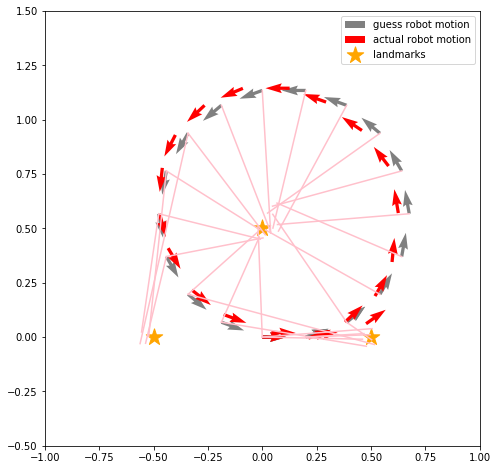

In [8]:
robot = Robot(0, 0, 0)
guess_id = 0
    
for i in range(0, 20):
    obss = robot.observation(actual_landmarks)
    robot.observed.append(len(obss) > 0)
    for obs in obss:
        e = HalfEdge(guess_id, obs.lid, robot.guessPose(), obs.distance, obs.direction, obs.orientation)
        obs_edges.append(e)

    if len(obss) > 0:
        guess_id += 1

    robot.move(0.2, math.pi / 180.0 * 20)

draw()
    
a = []
g = []
for i,obs in enumerate(robot.observed):
    if obs:
        a.append(robot.actual_poses[i])
        g.append(robot.guess_poses[i])

robot.actual_poses = a
robot.guess_poses = g
robot.observed = []

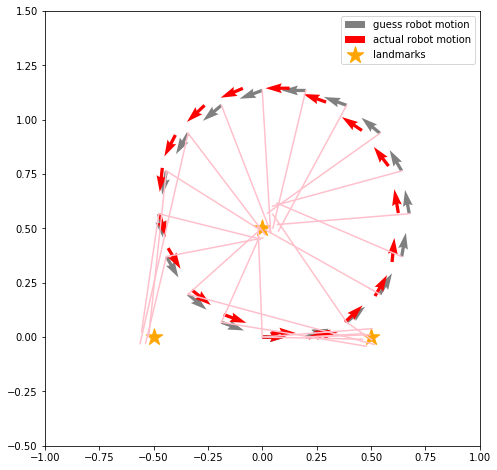

In [9]:
draw()

iteration: 0, diff: 0.530261
iteration: 1, diff: 0.002060
iteration: 2, diff: 0.000002


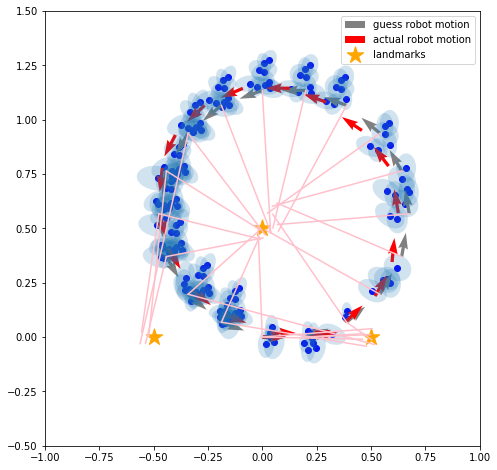

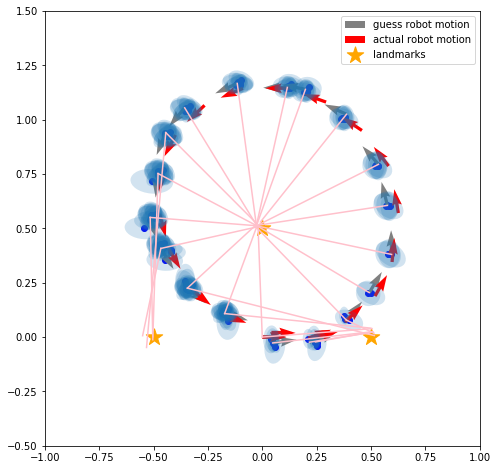

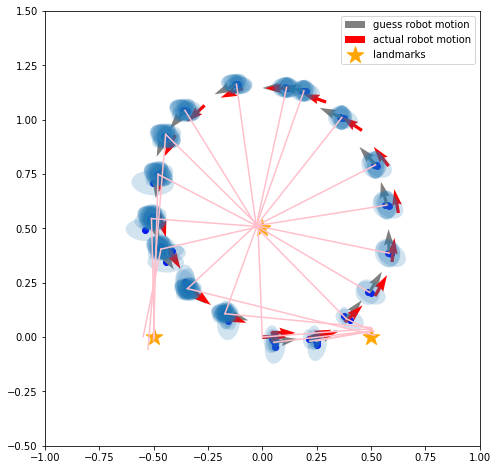

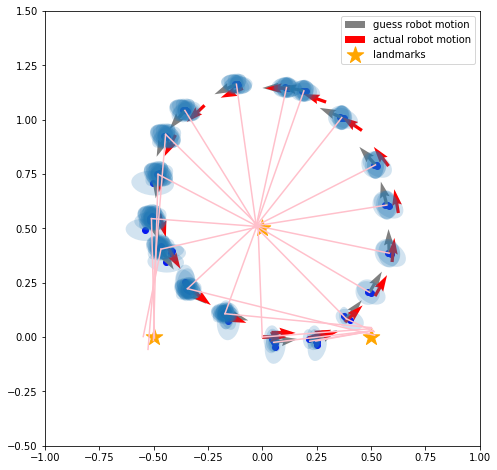

In [10]:
for itr in range(20):
    pos_edges = []

    for i in range(len(actual_landmarks.positions)):
        es = list(filter(lambda e: e.landmark_id == i, obs_edges))
        ps = list(itertools.combinations(es, 2))
        for p in ps:
            pos_edges.append(Edge(p[0], p[1]))
            
    draw(itr)

    n = len(robot.guess_poses) * 3
    matH = np.zeros((n, n))
    vecb = np.zeros((n, 1))

    for e in pos_edges:
        e.addInfo(matH, vecb)

    matH[0:3, 0:3] += np.identity(3) * 10000

    delta = - np.linalg.inv(matH).dot(vecb)

    for i,p in enumerate(robot.guess_poses):
        p[0] += delta[i * 3, 0]
        p[1] += delta[i * 3 + 1, 0]
        p[2] += delta[i * 3 + 2, 0]

    for e in obs_edges:
        e.update(robot.guess_poses)
    
    diff = delta.T.dot(delta)
    print("iteration: %d, diff: %f" % (itr, diff))
    if diff[0, 0] < 1.0e-5:        
        draw(itr + 1)
        break